In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")


# Training data preparation 

In [8]:
from scripts.tile_image import extract_tile_fixed
from sklearn.preprocessing import MinMaxScaler
with h5py.File("dataset/try_replace_with_rank.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
# ======= 資料儲存區 =======

train_L_tiles = []
train_labels = []
slides_ids = []
bad_spots = []
train_positions = []

# ======= 主迴圈 =======

with h5py.File("dataset/try1_masked.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    slide_ids = list(train_spot_tables.keys())

    for slide_id in slide_ids:
        if slide_id not in train_images:
            print(f"⚠️ Slide {slide_id} not found in HDF5, skipping.")
            continue

        image = train_images[slide_id][()]  # H x W x 3
        df = train_spot_tables[slide_id]

        # Step 4: 標準化座標
        ext_coords = df[['x', 'y']].values
        scaler = MinMaxScaler(feature_range=(-1, 1))
        coords_normalized = scaler.fit_transform(ext_coords)
        df[['x_normalized', 'y_normalized']] = coords_normalized

        for i, row in df.iterrows():
            x, y = int(row['x']), int(row['y'])
            nx, ny = row['x_normalized'], row['y_normalized']

            tile, padded = extract_tile_fixed(image, x, y, tile_size=78, pad_mode="edge")
            label = row.iloc[2:-2].values.astype(np.float32)
            train_positions.append(np.array([nx, ny], dtype=np.float32))
            train_L_tiles.append(tile)
            train_labels.append(label)
            slides_ids.append(slide_id)
            
            if padded is not None:
                bad_spots.append((slide_id, padded[0], padded[1]))
                
print(f"⚠️ 共 {len(bad_spots)} 個 spot 發生 padding：")
for sid, x, y in bad_spots[:5]:
    print(f" - {sid}: ({x}, {y})")

⚠️ 共 0 個 spot 發生 padding：


In [3]:
import torch
import os
import albumentations as A
from scripts.tile_image import split_into_subtiles

save_dir = "dataset/try/train_data"
os.makedirs(save_dir, exist_ok=True)

start_counter = 0
print(f"📦 原始資料從 index {start_counter} 開始儲存...")

for i, (l_tile, label, slide_id, position ) in enumerate(zip(train_L_tiles, train_labels, slides_ids,train_positions)):
    try:
        center_tile = l_tile  # 9 tiles
        subtiles = split_into_subtiles(center_tile)
        
        if len(subtiles) !=9 :
            print(f"{i} have wrong size {len(subtiles)}")
        data = {
            "tile": center_tile,
            "subtiles": np.stack(subtiles),
            "label": label,
            "source_idx": i,  # 🔁 可以追蹤來自第幾筆原始資料
            "slide_idx": slide_id,  # 🔁 可以追蹤來自第幾筆原始資料
            "position": position,
        }
        
        file_path = os.path.join(save_dir, f"tile_{start_counter + i:06d}.pt")
        torch.save(data, file_path)

    except Exception as e:
        print(f"❌ 第 {i} 筆資料儲存失敗：{e}")
print(f"✅ 原始資料已儲存至 {save_dir}/original_data.pt, 共 {len(train_L_tiles)} 筆資料。")


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.7 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


📦 原始資料從 index 0 開始儲存...
✅ 原始資料已儲存至 dataset/try/train_data/original_data.pt, 共 8348 筆資料。


🧪 Visualizing: tile_005707.pt


/Users/deweywang/Desktop/GitHub/HEVisum/scripts/valid_tile.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


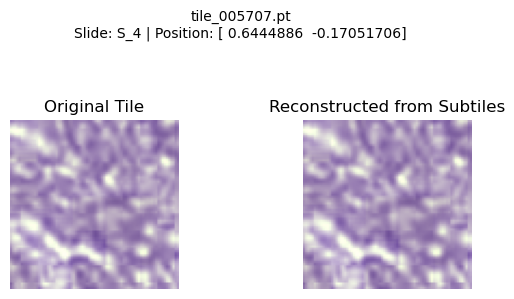

In [ ]:
from scripts.valid_tile import visualize_random_sample
visualize_random_sample(save_dir)


# Test data preparation

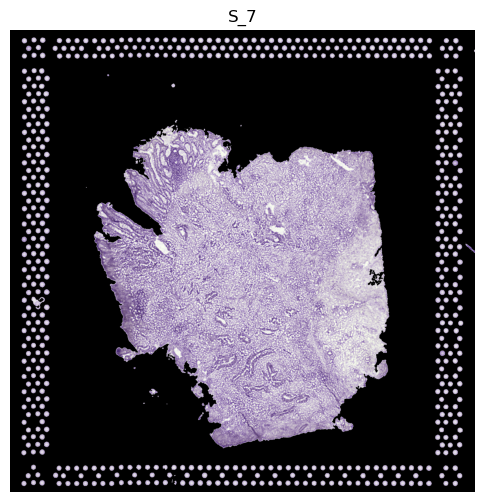

In [5]:
# Visualize Test slide ('S_7')
with h5py.File("dataset/try1_masked.h5", "r") as h5file:
    test_images = h5file["images/Test"]

    sample = 'S_7'
    image = np.array(test_images[sample])
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [4]:
# Display spot table for Test slide (only the spot coordinates on 2D array)
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    print(test_spots.keys())
    spot_array = np.array(test_spots['S_7'])
    test_spot_table = pd.DataFrame(spot_array)
    
# Show the test spots coordinates for slide 'S_7'
test_spot_table

<KeysViewHDF5 ['S_7']>


,x,y,Test_Set
0,1499,1260,2
1,1435,1503,2
2,558,1082,2
3,736,1304,1
4,1257,1592,1
...,...,...,...
2083,736,639,2
2084,1016,684,2
2085,1181,839,2
2086,735,1436,1


In [10]:
import h5py
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scripts.tile_image import split_into_subtiles

test_tiles = []
test_subtiles = []
bad_spots =[]
test_positions = []
source_idxs = []
with h5py.File("dataset/try1_masked.h5", "r") as h5file:
    test_images = h5file["images/Test"]

    slide_ids = list(test_images.keys())  # e.g., only ['S_7']
    # Step 4: 標準化座標
    df = test_spot_table
    image = np.array(test_images['S_7'])

    ext_coords = df[['x', 'y']].values
    scaler = MinMaxScaler(feature_range=(-1, 1))
    coords_normalized = scaler.fit_transform(ext_coords)
    df[['x_normalized', 'y_normalized']] = coords_normalized
    
    for i, row in df.iterrows():
        x, y = int(row['x']), int(row['y'])
        nx, ny = row['x_normalized'], row['y_normalized']

        tile, padded = extract_tile_fixed(image, x, y, tile_size=78)

        subtiles = split_into_subtiles(tile, 3)  # 9 tiles

        
        test_positions.append(np.array([nx, ny], dtype=np.float32))  # ✅ 修正

        test_tiles.append(tile)
        test_subtiles.append(subtiles)  # ✅ 存入
        
        source_idxs.append(i)
        if padded is not None:
            bad_spots.append((slide_id, padded[0], padded[1]))
                
print(f"⚠️ 共 {len(bad_spots)} 個 spot 發生 padding：")
for sid, x, y in bad_spots[:5]:
    print(f" - {sid}: ({x}, {y})")

⚠️ 共 0 個 spot 發生 padding：


In [ ]:
import torch
import os
output_dir = "dataset/try/test/"

os.makedirs(output_dir, exist_ok=True)
best_model_path = os.path.join(output_dir, "test_dataset.pt")

torch.save({
    'tiles': test_tiles,
    'subtiles': test_subtiles,
    'position': test_positions,
    'source_idx':source_idxs,
}, best_model_path)



print(f"✅ save the test dataset in ！{output_dir}")


✅ 所有資料已成功儲存到 final_data 資料夾！
